In [1]:
# import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

In [2]:
# import data
austin_listings = pd.read_csv('./data/austin_listings.csv', low_memory=False)
austin_reviews = pd.read_csv('./data/austin_reviews.csv', low_memory=False)
sf_reviews = pd.read_csv('./data/sanfrancisco_reviews.csv', low_memory=False)
sf_listings = pd.read_csv('./data/sanfrancisco_listings.csv', low_memory=False)

<h2> Preprocessing </h2>

In [3]:
# check Austin listings dataframe shape

austin_listings.shape

(11668, 106)

In [4]:
# check San Francisco listings dataframe shape

sf_listings.shape

(8138, 106)

In [5]:
# combine Austin listings and San Francisco listings dataframe

result_listings = austin_listings.append(sf_listings)
result_listings

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
1,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
3,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.12
4,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8133,43103703,https://www.airbnb.com/rooms/43103703,20200407152614,2020-04-08,San Francisco Home in the Heart of Lower Haight,Lovingly furnished and private studio with que...,NaN,Lovingly furnished and private studio with que...,none,NaN,...,t,f,flexible,f,f,1,1,0,0,NaN
8134,43105611,https://www.airbnb.com/rooms/43105611,20200407152614,2020-04-07,UP to 10 First Responders WANTED for 3 LEVELS ...,IDEAL HOME FOR PEOPLE ON THE FRONTLINES OF THE...,This remodeled Edwardian House in the prime lo...,IDEAL HOME FOR PEOPLE ON THE FRONTLINES OF THE...,none,Distance to SF attractions: West Portal- 5 min...,...,t,f,flexible,f,f,4,1,1,2,NaN
8135,43116773,https://www.airbnb.com/rooms/43116773,20200407152614,2020-04-07,Furnished 3 bedroom house,This newly renovated and modern house is perfe...,"This Designer house is located in the ""safer"" ...",This newly renovated and modern house is perfe...,none,Smack in the middle of the vibrant Valencia co...,...,f,f,flexible,f,f,2,2,0,0,NaN
8136,43125044,https://www.airbnb.com/rooms/43125044,20200407152614,2020-04-08,Beautiful Room Near Ghirardelli Square for Sublet,Beautifully furnished private room in a two be...,NaN,Beautifully furnished private room in a two be...,none,NaN,...,t,f,flexible,f,f,1,0,1,0,NaN


In [6]:
# check Austin reviews dataframe shape
austin_reviews.shape

(370044, 6)

In [7]:
# check San Francisco reviews dataframe shape

sf_reviews.shape

(366708, 6)

In [8]:
# combine the Austin and San Francisco dataframe reviews

result_reviews = austin_reviews.append(sf_reviews)

# drop id 
result_reviews = result_reviews.drop('id', axis=1)
result_reviews

,listing_id,date,reviewer_id,reviewer_name,comments
0,2265,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...
...,...,...,...,...,...
366703,42629673,2020-03-12,56865457,Heather,"While the photos spoke to high end, I truly wa..."
366704,42629673,2020-03-17,329621106,Chris,"I've stayed at many Airbnb's in the past, Bill..."
366705,42692601,2020-03-15,215064139,Kendra,This place is great! Loved that there was a gy...
366706,42761596,2020-03-13,280181385,Myron,Really awesome spot in a great location!!\nHos...


In [9]:
# rename id column

result_reviews.rename(columns={'listing_id':'id'}, inplace=True)
print(result_reviews.columns.values)

['id' 'date' 'reviewer_id' 'reviewer_name' 'comments']


In [10]:
result_reviews.head(n=5)

,id,date,reviewer_id,reviewer_name,comments
0,2265,2009-03-17,7538,Niall,I stayed here during SXSW and had a really ple...
1,2265,2009-03-22,10029,Michael,"Great place, close enough to everything downto..."
2,2265,2011-03-16,61677,Gustaf,We had a great time in Austin staying at Paddy...
3,2265,2012-03-15,1523753,Noah,We had a great stay at Zen East for South By S...
4,2265,2012-03-19,1547660,Melissa,I arrived late in the evening so did not meet ...


In [11]:
result_listings.head(n=5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20200317143754,2020-03-17,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
1,5245,https://www.airbnb.com/rooms/5245,20200317143754,2020-03-17,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,https://www.airbnb.com/rooms/5456,20200317143754,2020-03-17,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want...,...,f,f,strict_14_with_grace_period,f,t,1,1,0,0,3.94
3,5769,https://www.airbnb.com/rooms/5769,20200317143754,2020-03-17,NW Austin Room,NaN,Looking for a comfortable inexpensive room to ...,Looking for a comfortable inexpensive room to ...,none,Quiet neighborhood with lots of trees and good...,...,f,f,moderate,t,t,1,0,1,0,2.12
4,6413,https://www.airbnb.com/rooms/6413,20200317143754,2020-03-17,Gem of a Studio near Downtown,"Great studio apartment, perfect for couples or...",!!!!! SXSW info !!!!! Presently open (again!) ...,"Great studio apartment, perfect for couples or...",none,Travis Heights is one of the oldest neighborho...,...,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.90


In [12]:
comb_reviews = result_reviews.merge(result_listings, how="inner", on='id' )
comb_reviews = comb_reviews[['id', 'date', 'reviewer_name', 'reviewer_id', 'comments', 'review_scores_rating', 'review_scores_accuracy']]
comb_reviews

,id,date,reviewer_name,reviewer_id,comments,review_scores_rating,review_scores_accuracy
0,2265,2009-03-17,Niall,7538,I stayed here during SXSW and had a really ple...,93.0,9.0
1,2265,2009-03-22,Michael,10029,"Great place, close enough to everything downto...",93.0,9.0
2,2265,2011-03-16,Gustaf,61677,We had a great time in Austin staying at Paddy...,93.0,9.0
3,2265,2012-03-15,Noah,1523753,We had a great stay at Zen East for South By S...,93.0,9.0
4,2265,2012-03-19,Melissa,1547660,I arrived late in the evening so did not meet ...,93.0,9.0
...,...,...,...,...,...,...,...
736747,42629673,2020-03-12,Heather,56865457,"While the photos spoke to high end, I truly wa...",100.0,10.0
736748,42629673,2020-03-17,Chris,329621106,"I've stayed at many Airbnb's in the past, Bill...",100.0,10.0
736749,42692601,2020-03-15,Kendra,215064139,This place is great! Loved that there was a gy...,100.0,10.0
736750,42761596,2020-03-13,Myron,280181385,Really awesome spot in a great location!!\nHos...,100.0,10.0


In [13]:
def check_null_columns(df):
    '''List all columns with missing values
    
    Input:
        df: Dataframe

    Returns:
        Dataframe: a dataframe with column names, number of missing values, and percentage of missing values
    '''
    cols = df.columns[df.isnull().sum() >= 0]
    df_null = pd.DataFrame(df[cols].isnull().sum().sort_values(), columns=['Number of Nulls'])
    df_null['% of Nulls'] = df[cols].isnull().mean().sort_values() * 100
    
    return df_null

In [14]:
check_null_columns(comb_reviews)

,Number of Nulls,% of Nulls
id,0,0.000000
date,0,0.000000
reviewer_name,0,0.000000
reviewer_id,0,0.000000
review_scores_rating,204,0.027689
comments,389,0.052799
review_scores_accuracy,5554,0.753849


In [15]:
# drop all null rows

comb_reviews.dropna(inplace=True)
comb_reviews.shape

(730809, 7)

In [16]:
# check for null columns again

check_null_columns(comb_reviews)

,Number of Nulls,% of Nulls
id,0,0.0
date,0,0.0
reviewer_name,0,0.0
reviewer_id,0,0.0
comments,0,0.0
review_scores_rating,0,0.0
review_scores_accuracy,0,0.0


<h1>What are property renters saying about their experiences in reviews ?</h1>

In [17]:
# convert review score rating to integer

comb_reviews["review_scores_rating"] = comb_reviews["review_scores_rating"].astype(int)
comb_reviews["review_scores_rating"]

0          93
1          93
2          93
3          93
4          93
         ... 
736747    100
736748    100
736749    100
736750    100
736751    100
Name: review_scores_rating, Length: 730809, dtype: int64

In [18]:
def sentiments(col):
    '''
    Function classify ratings to positive, negative and neutral
    
    Args:
        col: the name of the column needed to be classified
        
    Returns:
        string: classification status
    '''
    if (col > 50):
        return "Positive"
    elif col < 50:
        return "Negative"
    elif col == 50:
        return "Neutral"
    
# Label the data sets with sentiments

comb_reviews["class"] = comb_reviews["review_scores_rating"].apply(sentiments)
comb_reviews

,id,date,reviewer_name,reviewer_id,comments,review_scores_rating,review_scores_accuracy,class
0,2265,2009-03-17,Niall,7538,I stayed here during SXSW and had a really ple...,93,9.0,Positive
1,2265,2009-03-22,Michael,10029,"Great place, close enough to everything downto...",93,9.0,Positive
2,2265,2011-03-16,Gustaf,61677,We had a great time in Austin staying at Paddy...,93,9.0,Positive
3,2265,2012-03-15,Noah,1523753,We had a great stay at Zen East for South By S...,93,9.0,Positive
4,2265,2012-03-19,Melissa,1547660,I arrived late in the evening so did not meet ...,93,9.0,Positive
...,...,...,...,...,...,...,...,...
736747,42629673,2020-03-12,Heather,56865457,"While the photos spoke to high end, I truly wa...",100,10.0,Positive
736748,42629673,2020-03-17,Chris,329621106,"I've stayed at many Airbnb's in the past, Bill...",100,10.0,Positive
736749,42692601,2020-03-15,Kendra,215064139,This place is great! Loved that there was a gy...,100,10.0,Positive
736750,42761596,2020-03-13,Myron,280181385,Really awesome spot in a great location!!\nHos...,100,10.0,Positive


In [19]:
sample_reviews = comb_reviews.groupby('class').size().reset_index(name="count")
sample_reviews['%count'] = sample_reviews['count']/sum(sample_reviews['count']) * 100


sample_reviews

,class,count,%count
0,Negative,68,0.009305
1,Neutral,17,0.002326
2,Positive,730724,99.988369


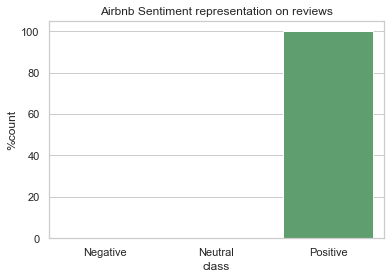

In [20]:
# visualize proportion of sentiments

sns.set(style="whitegrid")
tips = sns.load_dataset("tips")
ax = sns.barplot(x="class", y="%count", data=sample_reviews)
ax.set_title('Airbnb Sentiment representation on reviews')
plt.rcParams['figure.figsize']=(13,13)
plt.savefig('./plots/rating_status.png', bbox_inches='tight')


In [21]:
comb_reviews.head(n=2)

,id,date,reviewer_name,reviewer_id,comments,review_scores_rating,review_scores_accuracy,class
0,2265,2009-03-17,Niall,7538,I stayed here during SXSW and had a really ple...,93,9.0,Positive
1,2265,2009-03-22,Michael,10029,"Great place, close enough to everything downto...",93,9.0,Positive


In [22]:
# select a comment
comb_reviews.iloc[0,4]


'I stayed here during SXSW and had a really pleasant stay.  The house is a very relaxing environment and Paddy is both a friendly and professional host. '

<h2>Sentiment Analysis</h2>

We will extract some features to determine a comment's sentiment using the Bag of words strategy

<h3>Text preprocessing:</h3>
<ul>
<li>Tokenization (extracting words and sentences from input)</li>
<li>Apply regex to remove punctuations, whitespaces from words</li>
<li>Apply Stopwords to remove stopwords with nltk corpus </li>
<li>Apply stemming For example: “Flying” is a word and its suffix is “ing”, if we remove “ing” from “Flying” then we will get base word or root word which is “Fly”.This suffix is used to create a new word from the original stem word.</li>
<li>Apply lemmatization which links words with similar meaning to one word. </li>
<li>Create bag of words with redundant words. </li>
<li>Remove irrelevant words(filtering "this"and three lettered words). </li>
<li>Counting occurence (builds a dictionary of features with popular words for each review in a list document)</li>
</ul>

In [23]:
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer

def tokenize_words_Sents(sent):
    '''Function to take text and split into words and sentences
    
    Input:
        text: string

    Returns:
        List: tokenized words and sentences
    '''
    return word_tokenize(sent),sent_tokenize(sent)
 
def regexp_tokenizer(sent):
    '''Function to split sentences using regular expression(searches for groups that have alphanumerics and removes whitespaces)
    
    Input:
        text: tokenized strings

    Returns: 
        List: strings matched with either the tokens or the separators between tokens.
    '''
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(sent)

words,sents = tokenize_words_Sents(comb_reviews.iloc[0,4])
print("Words: ",words)
print("Sents: ",sents)


Words:  ['I', 'stayed', 'here', 'during', 'SXSW', 'and', 'had', 'a', 'really', 'pleasant', 'stay', '.', 'The', 'house', 'is', 'a', 'very', 'relaxing', 'environment', 'and', 'Paddy', 'is', 'both', 'a', 'friendly', 'and', 'professional', 'host', '.']
Sents:  ['I stayed here during SXSW and had a really pleasant stay.', 'The house is a very relaxing environment and Paddy is both a friendly and professional host.']


In [24]:
from nltk.corpus import stopwords

def remove_stop_words(sent):
    '''Function to remove stop words present in NLTK corpus from our list of words
    
    Input:
        List: tokenized words

    Returns:
        List: 1. words not in nltk corpus
         ''   2. words without stopwords
    '''
    stop_words = set(stopwords.words("english"))
    filtered_words = []
    for w in sent:
        if w not in stop_words:
            filtered_words.append(w)
    return stop_words,filtered_words

def remove_stop_word(sent):
    '''Function to remove stop words present in NLTK corpus from our list of words
    
    Input:
        List: tokenized words

    Returns:
        List: words not in stopwords
    '''
    stop_words = set(stopwords.words("english"))
    filtered_words = []
    for w in sent:
        if w not in stop_words:
            filtered_words.append(w)
    return filtered_words

stop_words,filtered_words = remove_stop_words(words)
print(stop_words)
print(".................................Words.....................................")
print(words)
print(".................................Words filtered............................")
print(filtered_words)

{'of', 'there', 'been', 'weren', 'which', 'what', 'me', 'wouldn', "you'd", "needn't", "you'll", 'same', 'hadn', 'but', "that'll", 's', 'just', 'this', 'after', 'under', 'these', 'about', 'between', "you've", "mustn't", 'above', "hadn't", 'were', 'nor', 'before', 'are', 'it', 'and', "shan't", 'myself', 'mightn', 'she', 'when', 'hers', "she's", 'few', 'an', 'off', 't', "won't", 'up', 'some', 'ours', "don't", 'should', 'ma', 'each', 'll', 'who', 'o', 'being', 'out', "mightn't", 'all', 'herself', 'other', 'our', 'whom', "aren't", 'him', 'is', 'having', 'did', 'at', 're', 'yours', 'most', 'd', 'yourselves', "it's", 'has', 'to', 'through', 'hasn', 'their', 'against', 'below', 'where', 'm', 'couldn', 'didn', 'only', 'then', 'her', 'during', 'can', 'so', 'no', 'y', 'for', 'until', "you're", 'themselves', 'why', 'wasn', 'ourselves', 'while', "doesn't", 'from', 'had', 'with', 'its', 'further', 'by', 'such', "wasn't", "couldn't", 'very', 'both', 'them', 'once', 've', 'be', 'haven', 'on', 'needn',

In [25]:
from nltk.stem import PorterStemmer

def stemming_words(words):
    '''Function to shorten the lookup, and normalize sentences.
    
    Input:
        List: tokenized words

    Returns:
        List: lemmatized words(root words)
    '''
    Ps = PorterStemmer()
    stemmed_words = []
    for m in words:
        stemmed_words.append(Ps.stem(m))
    return stemmed_words
stemmed_words = stemming_words(filtered_words)
print(stemmed_words)

['I', 'stay', 'sxsw', 'realli', 'pleasant', 'stay', '.', 'the', 'hous', 'relax', 'environ', 'paddi', 'friendli', 'profession', 'host', '.']


In [26]:
from nltk.stem import WordNetLemmatizer

def lemmatizing_words(words):
    '''Function to replace synonyms.
    
    Input:
        List: filtered words

    Returns:
        List: root words
    '''
    lemma = WordNetLemmatizer()
    lemmatized_words = []
    for root in words:
        lemmatized_words.append(lemma.lemmatize(root))
    return lemmatized_words

lemmatized_words = lemmatizing_words(filtered_words)
print(lemmatized_words)

['I', 'stayed', 'SXSW', 'really', 'pleasant', 'stay', '.', 'The', 'house', 'relaxing', 'environment', 'Paddy', 'friendly', 'professional', 'host', '.']


In [27]:
#Extract words from comments and  Tokenize 
#RegExpTokenizer to use regex to eliminate punctuations

list_words =  [regexp_tokenizer(m) for m in list(comb_reviews['comments'])]
print(list_words[1], 'done tokenizing')

#remove stop_words

list_words =  [remove_stop_word(m) for m in list_words]
print(list_words[1], 'done removing stop words')

#Stemming

list_words = [lemmatizing_words(m) for m in list_words]
print(list_words[1], 'done lemmatizing')

['Great', 'place', 'close', 'enough', 'to', 'everything', 'downtown', 'Austin', 'has', 'yet', 'just', 'far', 'enough', 'to', 'be', 'relaxing', 'and', 'quiet', 'An', 'excellent', 'place', 'to', 'regroup', 'and', 'recharge', 'Paddy', 'respected', 'my', 'privacy', 'and', 'different', 'hours', 'The', 'place', 'is', 'clean', 'and', 'hip', 'I', 'would', 'stay', 'with', 'Paddy', 'again', 'You', 'must', 'be', 'okay', 'with', 'dogs'] done tokenizing
['Great', 'place', 'close', 'enough', 'everything', 'downtown', 'Austin', 'yet', 'far', 'enough', 'relaxing', 'quiet', 'An', 'excellent', 'place', 'regroup', 'recharge', 'Paddy', 'respected', 'privacy', 'different', 'hours', 'The', 'place', 'clean', 'hip', 'I', 'would', 'stay', 'Paddy', 'You', 'must', 'okay', 'dogs'] done removing stop words
['Great', 'place', 'close', 'enough', 'everything', 'downtown', 'Austin', 'yet', 'far', 'enough', 'relaxing', 'quiet', 'An', 'excellent', 'place', 'regroup', 'recharge', 'Paddy', 'respected', 'privacy', 'differe

In [28]:
from nltk import FreqDist
def bag_of_words(list_words):
    '''Function to model and represent frequent data.
    
    Input:
        List: filtered words

    Returns:
        List: list of frequent words
    '''
    all_words = []
    for m in list_words:
        for w in m:
            all_words.append(w.lower())
    all_words = FreqDist(all_words)
    return all_words

Famous words: 139172


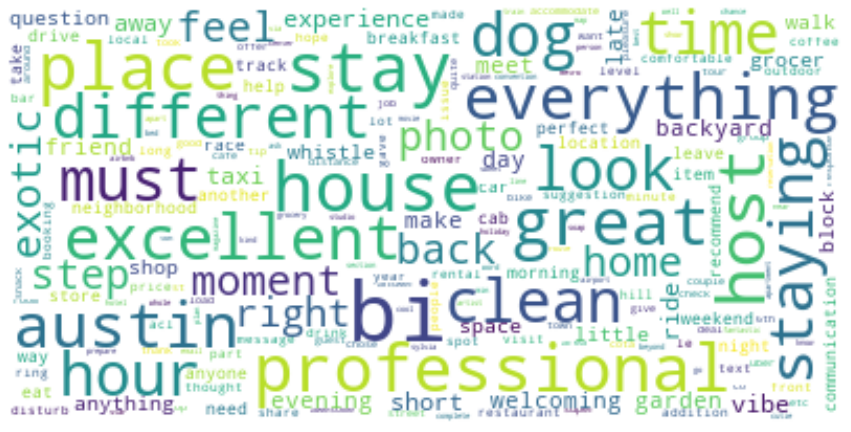

In [29]:
import matplotlib as mpl
from wordcloud import WordCloud
all_words = bag_of_words(list_words)
ax = plt.figure(figsize=(15,10))

# Generate a cloud image for frequent words
wordcloud = WordCloud(background_color='white',max_font_size=40).generate(' '.join(all_words.keys()))

# Display the generated image:

import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
print("Famous words:",len(all_words))

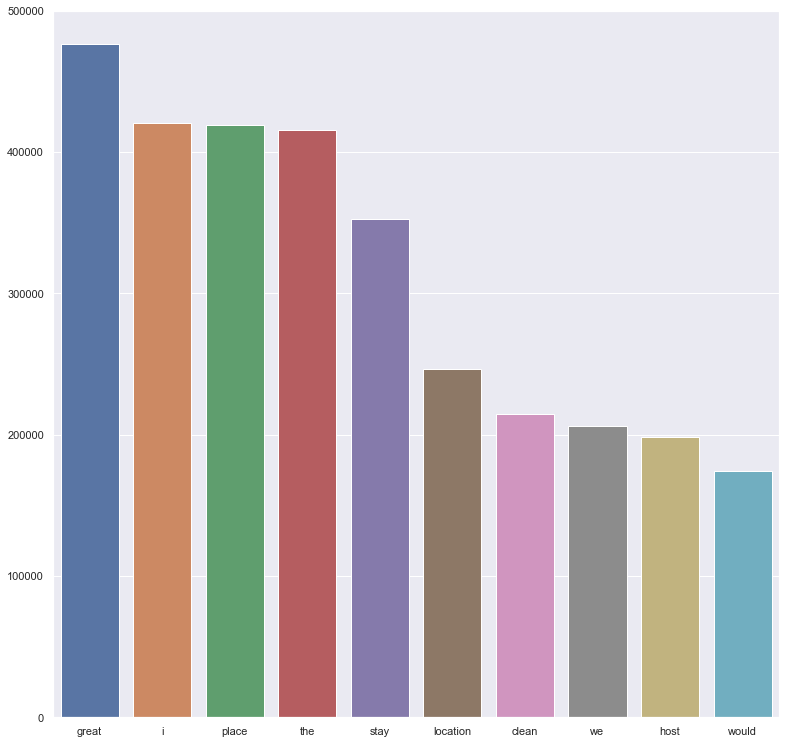

In [30]:
import seaborn as sns
# visualize popular words
from sklearn.manifold import TSNE
all_words = bag_of_words(list_words)
count = []
words  = []
for w in all_words.most_common(10):
    count.append(w[1])
    words.append(w[0])
sns.set_style("darkgrid")
sns.barplot(words,count)

In [31]:

#ListWords To lower case
def remove_irrelevent_words(list_words):
    '''Function to remove irrelevant words still contained after stopwords removal.
    
    Input:
        List: filtered words

    Returns:
        List: words
    '''
    list_words1 = [] 
    for m in list_words:
        l = [item.lower() for item in m]
        list_words1.append(l)
    list_words = list_words1
    #elimnate words
    for m in list_words:
        for w in m:
            if len(w) <=3:
                m.remove(w)
            if w == 'this':
                m.remove(w)
    return list_words

All Words length  133655


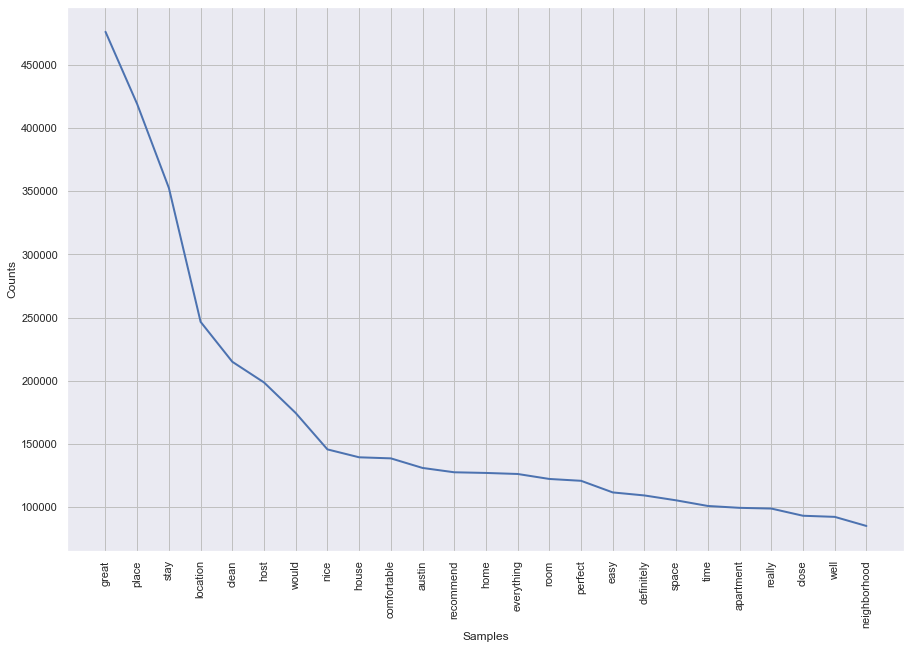

In [32]:
# Figures inline and set visualization style
list_words = remove_irrelevent_words(list_words)
all_words = bag_of_words(list_words)
print("All Words length ",len(all_words))
%matplotlib inline
sns.set()
ax = plt.figure(figsize=(15,10))# Create freq distribution and plot
freqdist1 = FreqDist(all_words)
freqdist1.plot(25)

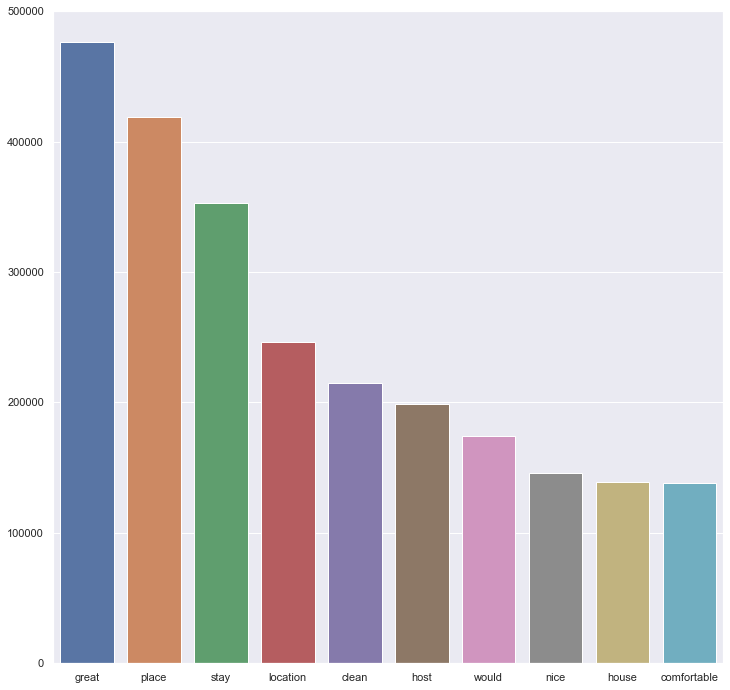

In [33]:
all_words = bag_of_words(list_words)
count = []
words  = []
for w in all_words.most_common(10):
    count.append(w[1])
    words.append(w[0])
sns.set_style("darkgrid")
plt.rcParams['figure.figsize']=(12,12)
sns.barplot(words,count)

In [34]:
import random
def create_document(comb_reviews,list_words):
    '''Function to create a document with a list of words and associated class.
    
    Input:
        Dataframe: target class
        List: preprocessed words

    Returns:
        Tuple: document
    '''
    list_class = list(comb_reviews['class'])
    documents =  []
    for m in range(len(list_words)):
        documents.append((list_words[m],list_class[m]))
    #shuffle
    random.shuffle(documents)
    return documents
#Review docs
documents = create_document(comb_reviews,list_words)
print(documents[1])

(['apartment', 'exactly', 'listed', 'luxurious', 'fabulous', 'made', 'great', 'first', 'trip', 'austin', 'location', 'excellent', 'walkable', 'boyfriend', 'could', 'stop', 'complimenting', 'little', 'thing', 'place', 'wait', 'stay', 'hopefully', 'soon'], 'Positive')


In [35]:
def find_features(document,all_words,num_of_words):
    '''function to create a dictionary of features with popular words for each review in the list document.
       The keys are the words in word_features. The values of each key are either true or false for 
       whether the feature appears in the review or not. 
    Input:
       string: sample review
       List: bag of words with the most repeated words
       num_of_words: specific number of repeated words

    Returns:
        Dictionary: features with repeated words for each review, festures as keys and its existence as boolean
    '''
    most_comm_word = []    
    for w in all_words.most_common(num_of_words):
        most_comm_word.append(w[0])

    word_features = most_comm_word
    words = regexp_tokenizer(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features
find_features("I really love the balcony",all_words,150)

{'great': False,
 'place': False,
 'stay': False,
 'location': False,
 'clean': False,
 'host': False,
 'would': False,
 'nice': False,
 'house': False,
 'comfortable': False,
 'austin': False,
 'recommend': False,
 'home': False,
 'everything': False,
 'room': False,
 'perfect': False,
 'easy': False,
 'definitely': False,
 'space': False,
 'time': False,
 'apartment': False,
 'really': True,
 'close': False,
 'well': False,
 'neighborhood': False,
 'good': False,
 'super': False,
 'quiet': False,
 'also': False,
 'area': False,
 'restaurant': False,
 'downtown': False,
 'beautiful': False,
 'amazing': False,
 'check': False,
 'highly': False,
 'wonderful': False,
 'city': False,
 'back': False,
 'staying': False,
 'very': False,
 'need': False,
 'like': False,
 'loved': False,
 'needed': False,
 'experience': False,
 'francisco': False,
 'made': False,
 'helpful': False,
 'walk': False,
 'even': False,
 'lovely': False,
 'night': False,
 'little': False,
 'street': False,
 'friendly'

<h4>We have been able to create features for each reviews. The system is able to identify features and establish a match from unseen data. The next thing we would have done is to create a model to classify this features into positive, negative and neutral reviews. However, this is beyond the scope of this project.</h4>

We can see that Airbnb reviews has a proportion of positive reviews than any other type of reviews(negative, neutral). Some of the most frequently used words by customers in comments are also visualized above. 